<a href="https://colab.research.google.com/github/divya603/mortgage-default-prediction/blob/main/MLProject_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import accuracy_score,precision_score, confusion_matrix, classification_report, f1_score, make_scorer
from pydotplus import graph_from_dot_data
from IPython.display import display, HTML, Image
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
#Importing the data
s = '/Users/morganwaddington/Documents/Tandon/Classes/Machine-Learning/datasets/Loan_Default(in).csv'
df = pd.read_csv(s, encoding='utf-8')


In [ ]:
# First, we want to manage empty values because oversampling techniques like SMOTE cannot handle blanks.
# It's crucial to address missing data before applying any machine learning methods.

missing_value_count = df.isnull().sum()
columns_with_missing_values = missing_value_count[missing_value_count > 0]

print("\nColumns with missing values and their counts:")
print(columns_with_missing_values)


Columns with missing values and their counts:
loan_limit                    3344
approv_in_adv                  908
loan_purpose                   134
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
property_value               15098
income                        9150
age                            200
submission_of_application      200
LTV                          15098
dtir1                        24121
dtype: int64


In [ ]:
# Fill missing loan_limit values based on the distribution in entire loan population

columns_to_fill = ['loan_limit', 'approv_in_adv', 'loan_purpose', 'term', 'Neg_ammortization', 'income']

for col in columns_to_fill:

    col_distribution = df[col].value_counts(normalize=True)
    empty_locations = df[df[col].isna()].index
    random_fills = np.random.choice(
                                col_distribution.index,
                                size=len(empty_locations),
                                p=col_distribution.values)
    df.loc[empty_locations, col] = random_fills

print("Missing values after filling:")
print(df[columns_to_fill].isnull().sum())

Missing values after filling:
loan_limit           0
approv_in_adv        0
loan_purpose         0
term                 0
Neg_ammortization    0
income               0
dtype: int64


In [ ]:
# Missing AGE AND PROPERTY values are correlated 1:1 with defaulted loans
# Filling these missing values based on the distribution of ONLY defaulted loans
columns_to_fill = ['age', 'property_value']

defaulted_loans = df[df['Status'] == 1]

for col in columns_to_fill:
    col_distribution = defaulted_loans[col].value_counts(normalize=True)

    empty_locations = df[df[col].isna()].index

    random_fills = np.random.choice(
        col_distribution.index,
        size=len(empty_locations),
        p=col_distribution.values
    )

    df.loc[empty_locations, col] = random_fills

print("Missing values after filling:")
print(df[columns_to_fill].isnull().sum())

Missing values after filling:
age               0
property_value    0
dtype: int64


In [ ]:
top_10_values = df['age'].value_counts().head(10)
print(top_10_values)

age
45-54    34765
35-44    32854
55-64    32586
65-74    20776
25-34    19160
>74       7191
<25       1338
Name: count, dtype: int64


In [ ]:
# Dropping loans with missing or invalid LTV values
df = df[df['LTV'] <= 264]

print("Remaining missing values in 'LTV':", df['LTV'].isnull().sum())

Remaining missing values in 'LTV': 0


In [ ]:
# Dropped these cols because the missing values only occurred for defaulted loans,
# and there were no non-missing values in the defaulted category to sample from.
# As a result, it was not possible to fill these missing values using the same approach as other columns.

# Dropped DTI cause the data was nonsensical as discussed in paper.

columns_to_drop = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'dtir1']

df.drop(columns=columns_to_drop, inplace=True)


In [ ]:
# ONE HOT ENCODING
col_name = df.columns[df.dtypes == 'object'].tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

for col in col_name:
    transformed_array = encoder.fit_transform(df[[col]])
    new_feature_names = encoder.get_feature_names_out([col])
    encoded_df = pd.DataFrame(transformed_array, columns=new_feature_names)
    encoded_df.index = df.index
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(col, axis=1, inplace=True)

print("Dataset now has", df.shape[1], "columns.")

Dataset now has 69 columns.


In [ ]:
# Splitting the data into test and train
y = df['Status'].values
X = df.drop(columns=['Status']).values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [ ]:
#OVERSAMPLING - because we have a lot less defautled loans than current ones

print("Training set class distribution BEFORE oversampling:")
print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=1)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)


print("Training set class distribution AFTER oversampling:")
print(pd.Series(y_train_oversampled).value_counts())


Training set class distribution BEFORE oversampling:
0    89619
1    17233
Name: count, dtype: int64
Training set class distribution AFTER oversampling:
0    89619
1    89619
Name: count, dtype: int64


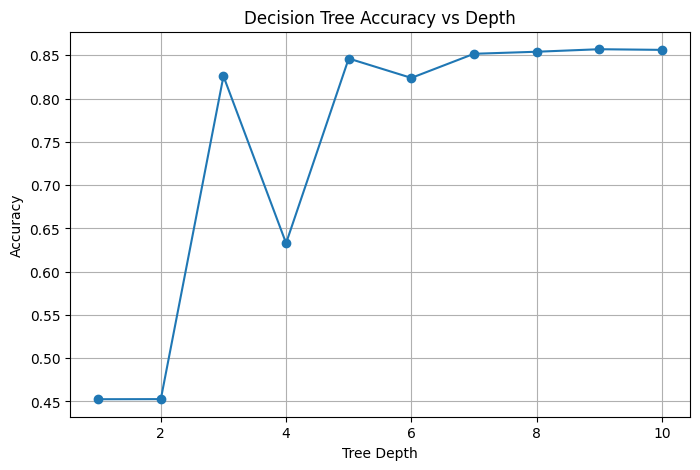

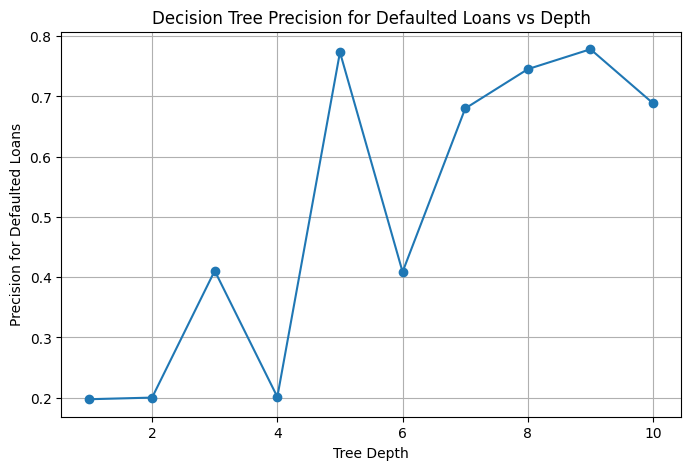

In [ ]:
#Testing decision tree model for accuracy and precision accross 10 depths to see which one is the best.
accuracy_results = []
precision_results = []

for depth in range(1, 11):
    tree_model = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=1)
    tree_model.fit(X_train_oversampled, y_train_oversampled)
    y_pred = tree_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append((depth, accuracy))

    precision = precision_score(y_test, y_pred, pos_label=1)
    precision_results.append((depth, precision))


depths, accuracies = zip(*accuracy_results)
plt.figure(figsize=(8, 5))
plt.plot(depths, accuracies, marker='o', linestyle='-')
plt.title('Decision Tree Accuracy vs Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

depths, precisions = zip(*precision_results)
plt.figure(figsize=(8, 5))
plt.plot(depths, precisions, marker='o', linestyle='-')
plt.title('Decision Tree Precision for Defaulted Loans vs Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Precision for Defaulted Loans')
plt.grid(True)
plt.show()


While depth 3 has good accuracy, the decision tree model suffers from poor precision in predicting defaulted loans.Precision becomes more respectable starting at depth 5, which is why we chose as the depth for our baseline model.
Deeper depths beyond 5 do not significantly improve performance and, in some cases, worsen it.
Additionally, deeper trees are harder to interpret visually (lack of space) and can likely suffer from overfitting.

In [ ]:
#Showing the confusion matrix for depth 3 and 5 which were the two lower depths with higher accuracies.
def print_results(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:')
    print(cm, '\n')
    report = classification_report(y_true, y_pred)
    print('Classification Report:')
    print(report)

for depth in [3, 5]:
    display(HTML(f"<h2>Gini - Depth {depth}:</h2>"))
    tree_model = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=1)
    tree_model.fit(X_train_oversampled, y_train_oversampled)
    y_pred = tree_model.predict(X_test)
    print_results(y_test, y_pred)



Confusion Matrix:
[[21283  1122]
 [ 3527   782]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22405
           1       0.41      0.18      0.25      4309

    accuracy                           0.83     26714
   macro avg       0.63      0.57      0.58     26714
weighted avg       0.79      0.83      0.80     26714



Confusion Matrix:
[[22320    85]
 [ 4019   290]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     22405
           1       0.77      0.07      0.12      4309

    accuracy                           0.85     26714
   macro avg       0.81      0.53      0.52     26714
weighted avg       0.84      0.85      0.79     26714



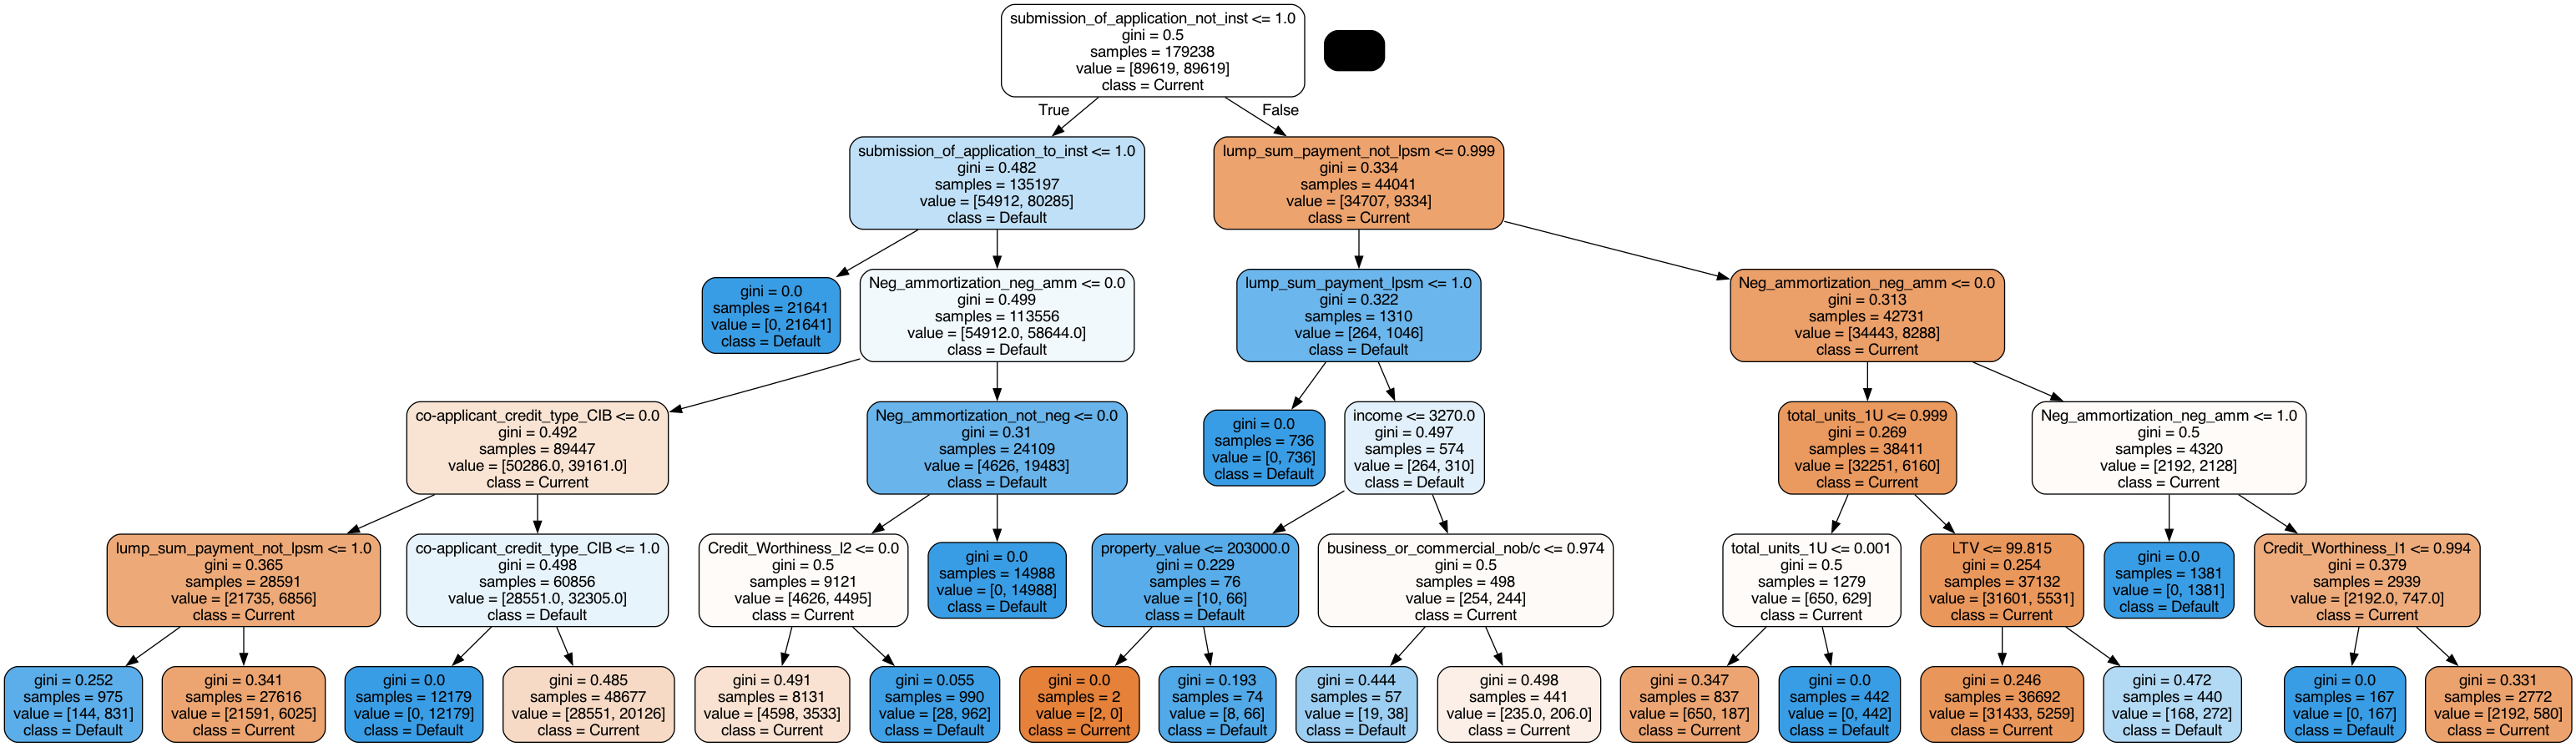

In [ ]:
display(HTML(f"<h1>Visualizing the Best Tree: Gini - Depth 5</h1>"))

tree_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1)
tree_model.fit(X_train_oversampled, y_train_oversampled)

feature_namess = [col for col in df.columns if col != 'Status']

dot_data = export_graphviz(tree_model,
                           filled=True,
                           rounded=True,
                           class_names=['Current', 'Default'],
                           feature_names=feature_namess,
                           out_file=None)

graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
#IMPLEMENTING XGBOOST // FINDING THE BEST PARAMS // APPLYING OVERSAMPLING AND UNDERSAMPLING

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 1, 5],
    'classifier__lambda': [1, 2, 3],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

sampling_strategies = [
    ('Oversampling (SMOTE)', SMOTE(random_state=1)),
    ('Undersampling (RandomUnderSampler)', RandomUnderSampler(random_state=1))
]

for strategy_name, sampler in sampling_strategies:
    display(HTML(f"<h1>Using {strategy_name}</h1>"))

    pipeline = Pipeline([
        ('sampler', sampler),
        ('classifier', XGBClassifier(random_state=1, eval_metric='logloss'))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred_xgb = best_model.predict(X_test)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy Score:", grid_search.best_score_)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_xgb))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb))


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__lambda': 3, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best Accuracy Score: 0.8731235753976039
Confusion Matrix:
[[22117   288]
 [ 3139  1170]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     22405
           1       0.80      0.27      0.41      4309

    accuracy                           0.87     26714
   macro avg       0.84      0.63      0.67     26714
weighted avg       0.86      0.87      0.84     26714



Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best Accuracy Score: 0.7471081865067338
Confusion Matrix:
[[17145  5260]
 [ 1484  2825]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22405
           1       0.35      0.66      0.46      4309

    accuracy                           0.75     26714
   macro avg       0.63      0.71      0.65     26714
weighted avg       0.83      0.75      0.77     26714

